In [ ]:
pip install san

  Preparing metadata (setup.py) ... done
  Created wheel for san: filename=san-1.2.0-py3-none-any.whl size=1198 sha256=574a7d5112a258d84abe868de0c7388190ff28ad27812fe32e145ee37b2a9e00
  Stored in directory: /root/.cache/pip/wheels/7e/6f/a7/0ad94e2596aa6c730302a321d06ed4a8e4a4d98a19a6e02ebd
Successfully built san


In [ ]:
pip install sanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade sanpy

In [ ]:
import san
san.ApiConfig.api_key = "4q72pluphyuz3cri_inldqulpsmopb3mc"

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# 🧱 Agent: Fetch and process data for multiple tokens, including sentiment-weighted total
def fetch_multiple_tokens_data_with_sentiment(tokens):
    # Get yesterday's date and the date from 2 years ago
    yesterday = datetime.today() - timedelta(1)
    two_years_back = datetime.today() - timedelta(365 * 2)

    # Format the dates in the required format (YYYY-MM-DD)
    from_date = two_years_back.strftime('%Y-%m-%d')
    to_date = yesterday.strftime('%Y-%m-%d')

    # Dictionary to store data for each token
    all_tokens_data = {}

    # Loop through each token in the list and fetch data
    for token in tokens:
        print(f"Fetching data for {token}...")

        # Fetch social volume data
        social_volume_data = san.get("social_volume_total",
                                     slug=token,
                                     from_date=from_date,
                                     to_date=to_date,
                                     interval="1d")

        # Fetch price data
        price_data = san.get("price_usd",
                             slug=token,
                             from_date=from_date,
                             to_date=to_date,
                             interval="1d")

        # Fetch sentiment-weighted total data
        sentiment_weighted_total_data = san.get("sentiment_weighted_total",
                                                slug=token,
                                                from_date=from_date,
                                                to_date=to_date,
                                                interval="1d")

        # Convert to DataFrames
        social_df = pd.DataFrame(social_volume_data)
        price_df = pd.DataFrame(price_data)
        sentiment_df = pd.DataFrame(sentiment_weighted_total_data)

        # Merge the three DataFrames on the 'datetime' column
        combined_df = pd.merge(social_df, price_df, left_on='datetime', right_on='datetime', how='inner')
        combined_df = pd.merge(combined_df, sentiment_df, left_on='datetime', right_on='datetime', how='inner')

        # Store the combined data for the token
        all_tokens_data[token] = combined_df

    return all_tokens_data


In [ ]:
# 🧱 Agent: Analyze and generate signals based on the fetched data for multiple tokens, considering sentiment-weighted total
def analyze_multiple_tokens_data_with_sentiment(all_tokens_data):
    # Dictionary to store processed data for each token
    all_tokens_analysis = {}

    # Loop through each token's data
    for token, combined_df in all_tokens_data.items():
        print(f"Processing data for {token}...")

        # Calculate daily returns based on the 'value_y' column (price data)
        combined_df['return'] = combined_df['value_y'].pct_change() * 100

        # Identify social volume spikes using 'value_x' for social volume
        combined_df['rolling_avg'] = combined_df['value_x'].rolling(window=7).mean()

        # Buy signal: when social volume spikes above 1.5x the rolling average and sentiment-weighted total is positive
        combined_df['buy_signal'] = (combined_df['value_x'] > (combined_df['rolling_avg'] * 1.5)) & (combined_df['value'] > 0)

        # Sell signal: when social volume drops below the rolling average, return is negative, and sentiment-weighted total is negative
        combined_df['sell_signal'] = (combined_df['value_x'] < combined_df['rolling_avg']) & (combined_df['return'] < 0) & (combined_df['value'] < 0)

        # Drop rows with missing values (NaN)
        combined_df = combined_df.dropna()
        combined_df.reset_index(inplace=True)  # This will turn the index into a regular column

        # Store the processed data for this token
        all_tokens_analysis[token] = combined_df

    return all_tokens_analysis


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# 🧱 Agent: Train the model for multiple tokens, including sentiment-weighted total
def train_multiple_tokens_models_with_sentiment(all_tokens_data):
    # Dictionary to store the trained models for each token
    all_models = {}

    # Loop through each token's data
    for token, combined_df in all_tokens_data.items():
        print(f"Training model for {token}...")

        # Feature selection (including sentiment-weighted total)
        X = combined_df[['value_x', 'value_y', 'return', 'rolling_avg', 'value']]  # Features
        y = combined_df['buy_signal'].astype(int)  # Target: buy_signal (binary classification)

        # Split the data into training and testing sets (80% train, 20% test)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the XGBoost classifier
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Avoid label encoder warning
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"Accuracy for {token}: {accuracy:.4f}")
        print(f"Confusion Matrix for {token}:")
        print(conf_matrix)

        # Feature importance (optional)
        xgb.plot_importance(model)

        # Store the trained model in the dictionary
        all_models[token] = model

    return all_models


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 🧱 Agent: Backtest the strategy with the model's predictions and calculate performance metrics for multiple tokens
def backtest_multiple_tokens_with_sentiment(all_tokens_data, all_models, initial_capital=10000):
    # Dictionary to store backtest results for each token
    all_backtest_results = {}

    # Loop through each token and backtest
    for token, combined_df in all_tokens_data.items():
        print(f"Backtesting strategy for {token}...")

        # Get the trained model for the current token
        model = all_models.get(token)

        if model is None:
            print(f"Model for {token} not found. Skipping backtest.")
            continue

        # Add predicted buy signals to the dataframe
        combined_df['predicted_buy_signal'] = model.predict(combined_df[['value_x', 'value_y', 'return', 'rolling_avg', 'value']])

        # Initialize portfolio variables
        capital = initial_capital  # Current capital
        positions = 0  # Number of tokens held
        portfolio_value = []  # List to track portfolio value over time
        buy_price = None  # Track the price at which tokens are bought

        # Simulate trades based on the predicted buy signals
        for index, row in combined_df.iterrows():
            # Buy signal: if the model predicts buy_signal == 1 and no tokens are held
            if row['predicted_buy_signal'] == 1 and positions == 0:
                positions = capital / row['value_y']  # Buy tokens at current price
                capital = 0  # All capital used for buying tokens
                buy_price = row['value_y']  # Track the price at which we bought

            # Sell signal: if the model predicts sell_signal == 1 and tokens are held
            elif row['sell_signal'] == 1 and positions > 0:
                capital = positions * row['value_y']  # Sell all tokens at current price
                positions = 0  # No tokens are held after selling
                buy_price = None  # Reset the buy price

            # Hold: when both buy and sell signals are false
            elif row['predicted_buy_signal'] == 0 and row['sell_signal'] == 0:
                # Holding the current position without action
                portfolio_value.append(capital + positions * row['value_y'])
                continue

            # Track portfolio value (capital + value of held positions)
            portfolio_value.append(capital + positions * row['value_y'])

        # Convert portfolio value to DataFrame for further analysis
        portfolio_df = pd.DataFrame(portfolio_value, columns=['portfolio_value'])
        portfolio_df['date'] = combined_df['datetime']  # Assuming 'datetime' column exists

        # Calculate total return
        total_return = (portfolio_df['portfolio_value'].iloc[-1] - initial_capital) / initial_capital * 100

        # Calculate drawdown (max drop from peak)
        portfolio_df['peak'] = portfolio_df['portfolio_value'].cummax()
        portfolio_df['drawdown'] = (portfolio_df['portfolio_value'] - portfolio_df['peak']) / portfolio_df['peak'] * 100
        max_drawdown = portfolio_df['drawdown'].min()

        # Calculate the Sharpe ratio
        portfolio_df['return'] = portfolio_df['portfolio_value'].pct_change() * 100  # Daily return
        average_daily_return = portfolio_df['return'].mean()
        risk_free_rate = 0  # Assuming risk-free rate is 0
        daily_volatility = portfolio_df['return'].std()
        sharpe_ratio = (average_daily_return - risk_free_rate) / daily_volatility

        # Store the backtest results for this token
        all_backtest_results[token] = {
            'portfolio_df': portfolio_df,
            'total_return': total_return,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio
        }

        # Display the results
        print(f"Total Return for {token}: {total_return:.2f}%")
        print(f"Maximum Drawdown for {token}: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio for {token}: {sharpe_ratio:.2f}")

        # Plot portfolio value over time
        portfolio_df.plot(x='date', y='portfolio_value', title=f'{token} Portfolio Value Over Time')
        plt.show()

    return all_backtest_results


Fetching data for aave...
Fetching data for sushi...
Processing data for aave...
Processing data for sushi...
Training model for aave...
Accuracy for aave: 0.9931
Confusion Matrix for aave:
[[134   0]
 [  1   9]]
Training model for sushi...
Accuracy for sushi: 0.9444
Confusion Matrix for sushi:
[[134   4]
 [  4   2]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-8-fbced5b8781c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['predicted_buy_signal'] = model.predict(combined_df[['value_x', 'value_y', 'return', 'rolling_avg', 'value']])


Backtesting strategy for aave...
Total Return for aave: 405.69%
Maximum Drawdown for aave: -19.69%
Sharpe Ratio for aave: 0.09


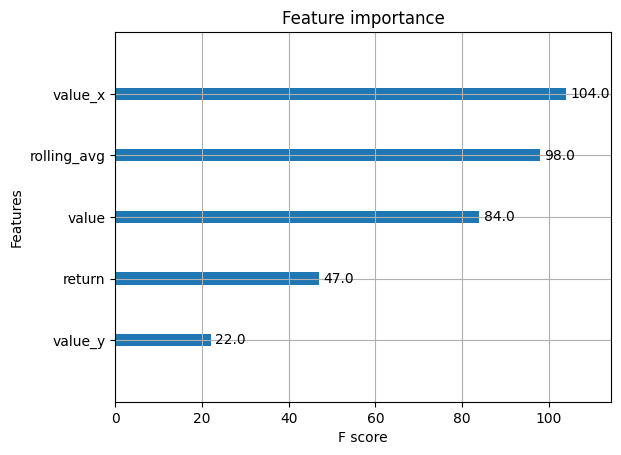

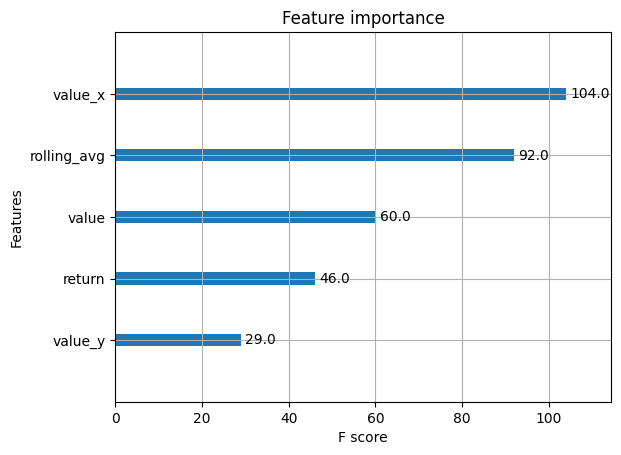

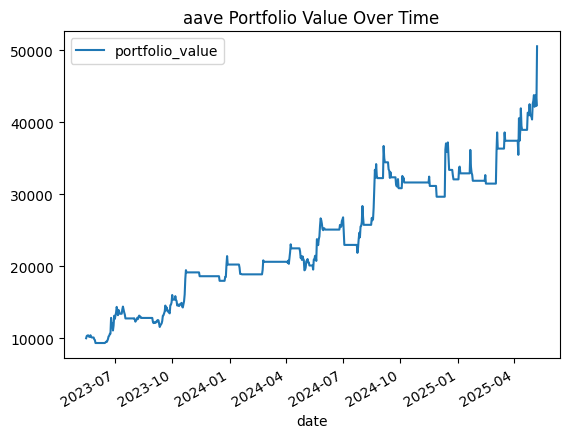

Backtesting strategy for sushi...
Total Return for sushi: -66.56%
Maximum Drawdown for sushi: -79.81%
Sharpe Ratio for sushi: -0.02


<ipython-input-8-fbced5b8781c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['predicted_buy_signal'] = model.predict(combined_df[['value_x', 'value_y', 'return', 'rolling_avg', 'value']])


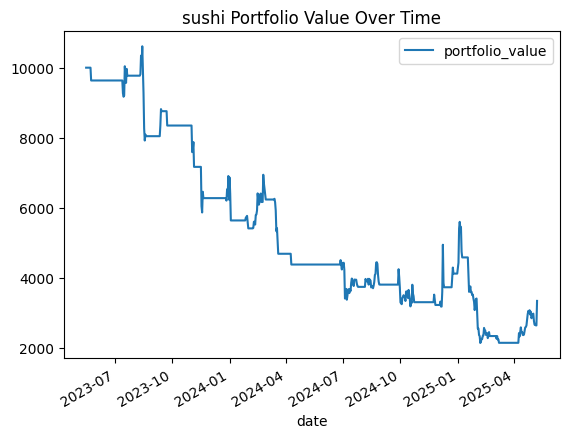

In [ ]:
# Fetch data for tokens
tokens = ['aave', 'sushi']
all_tokens_data = fetch_multiple_tokens_data_with_sentiment(tokens)

# Analyze and generate signals
analyzed_data = analyze_multiple_tokens_data_with_sentiment(all_tokens_data)
# Train models for each token
trained_models = train_multiple_tokens_models_with_sentiment(analyzed_data)

# Backtest the strategy
backtest_results = backtest_multiple_tokens_with_sentiment(analyzed_data, trained_models)